In [1]:
import utils.dataset_utils as dataset
import utils.train_utils as train

import numpy as np
import copy
import pickle

from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import preprocessing.GSP as GSP
from scipy.interpolate import interp1d
from scipy import ndimage


plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 500


In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [3]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
filenames = np.load(f"{file_location}FileNames.npy")
with open(f'{file_location}Sample_labels.pickle', 'rb') as f:
    labels = pickle.load(f)

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f]))

In [4]:
cunk = 20

for j, (f, img) in enumerate(zip(filenames, data)):   
    img = img[0]
    tmp = copy.copy(img.reshape(-1, img.shape[-1]))
    tmp = tmp.reshape(tmp.shape[0], cunk, -1)
    min_index = np.argmin(tmp, 2)[0]
    value = tmp[0,range(cunk),min_index]
    value = np.insert(value, 0, tmp[0,0,0])
    min_index = np.arange(0,tmp.shape[1]*tmp.shape[2],tmp.shape[2]) + min_index
    min_index = np.insert(min_index, 0, 0)
    if min_index[-1] != tmp.shape[1]*tmp.shape[2]-1:
        min_index = np.append(min_index, tmp.shape[1]*tmp.shape[2]-1)
        value = np.append(value, tmp[0,-1,-1])
    break
    
# for i in range(cunk):
#     plt.plot(range(tmp.shape[2]*i,tmp.shape[2]*(i+1)), tmp[0,i])

# plt.plot(min_index, value)

f2 = interp1d(min_index, value, kind='cubic')
x3 = f2(range(tmp.shape[1]*tmp.shape[2]))

In [5]:
for j, (f, img) in enumerate(zip(filenames, data)):   
    img = img[0]
    tmp = copy.copy(img.reshape(-1, img.shape[-1]))
    tmp1, tmp2 = GSP.split_Raman_af(GSP.smoothing(tmp, smooth=5, transition=10, spike_width=7), wavenumbers, 9)
    
    
    break

x = tmp
x2 = tmp2

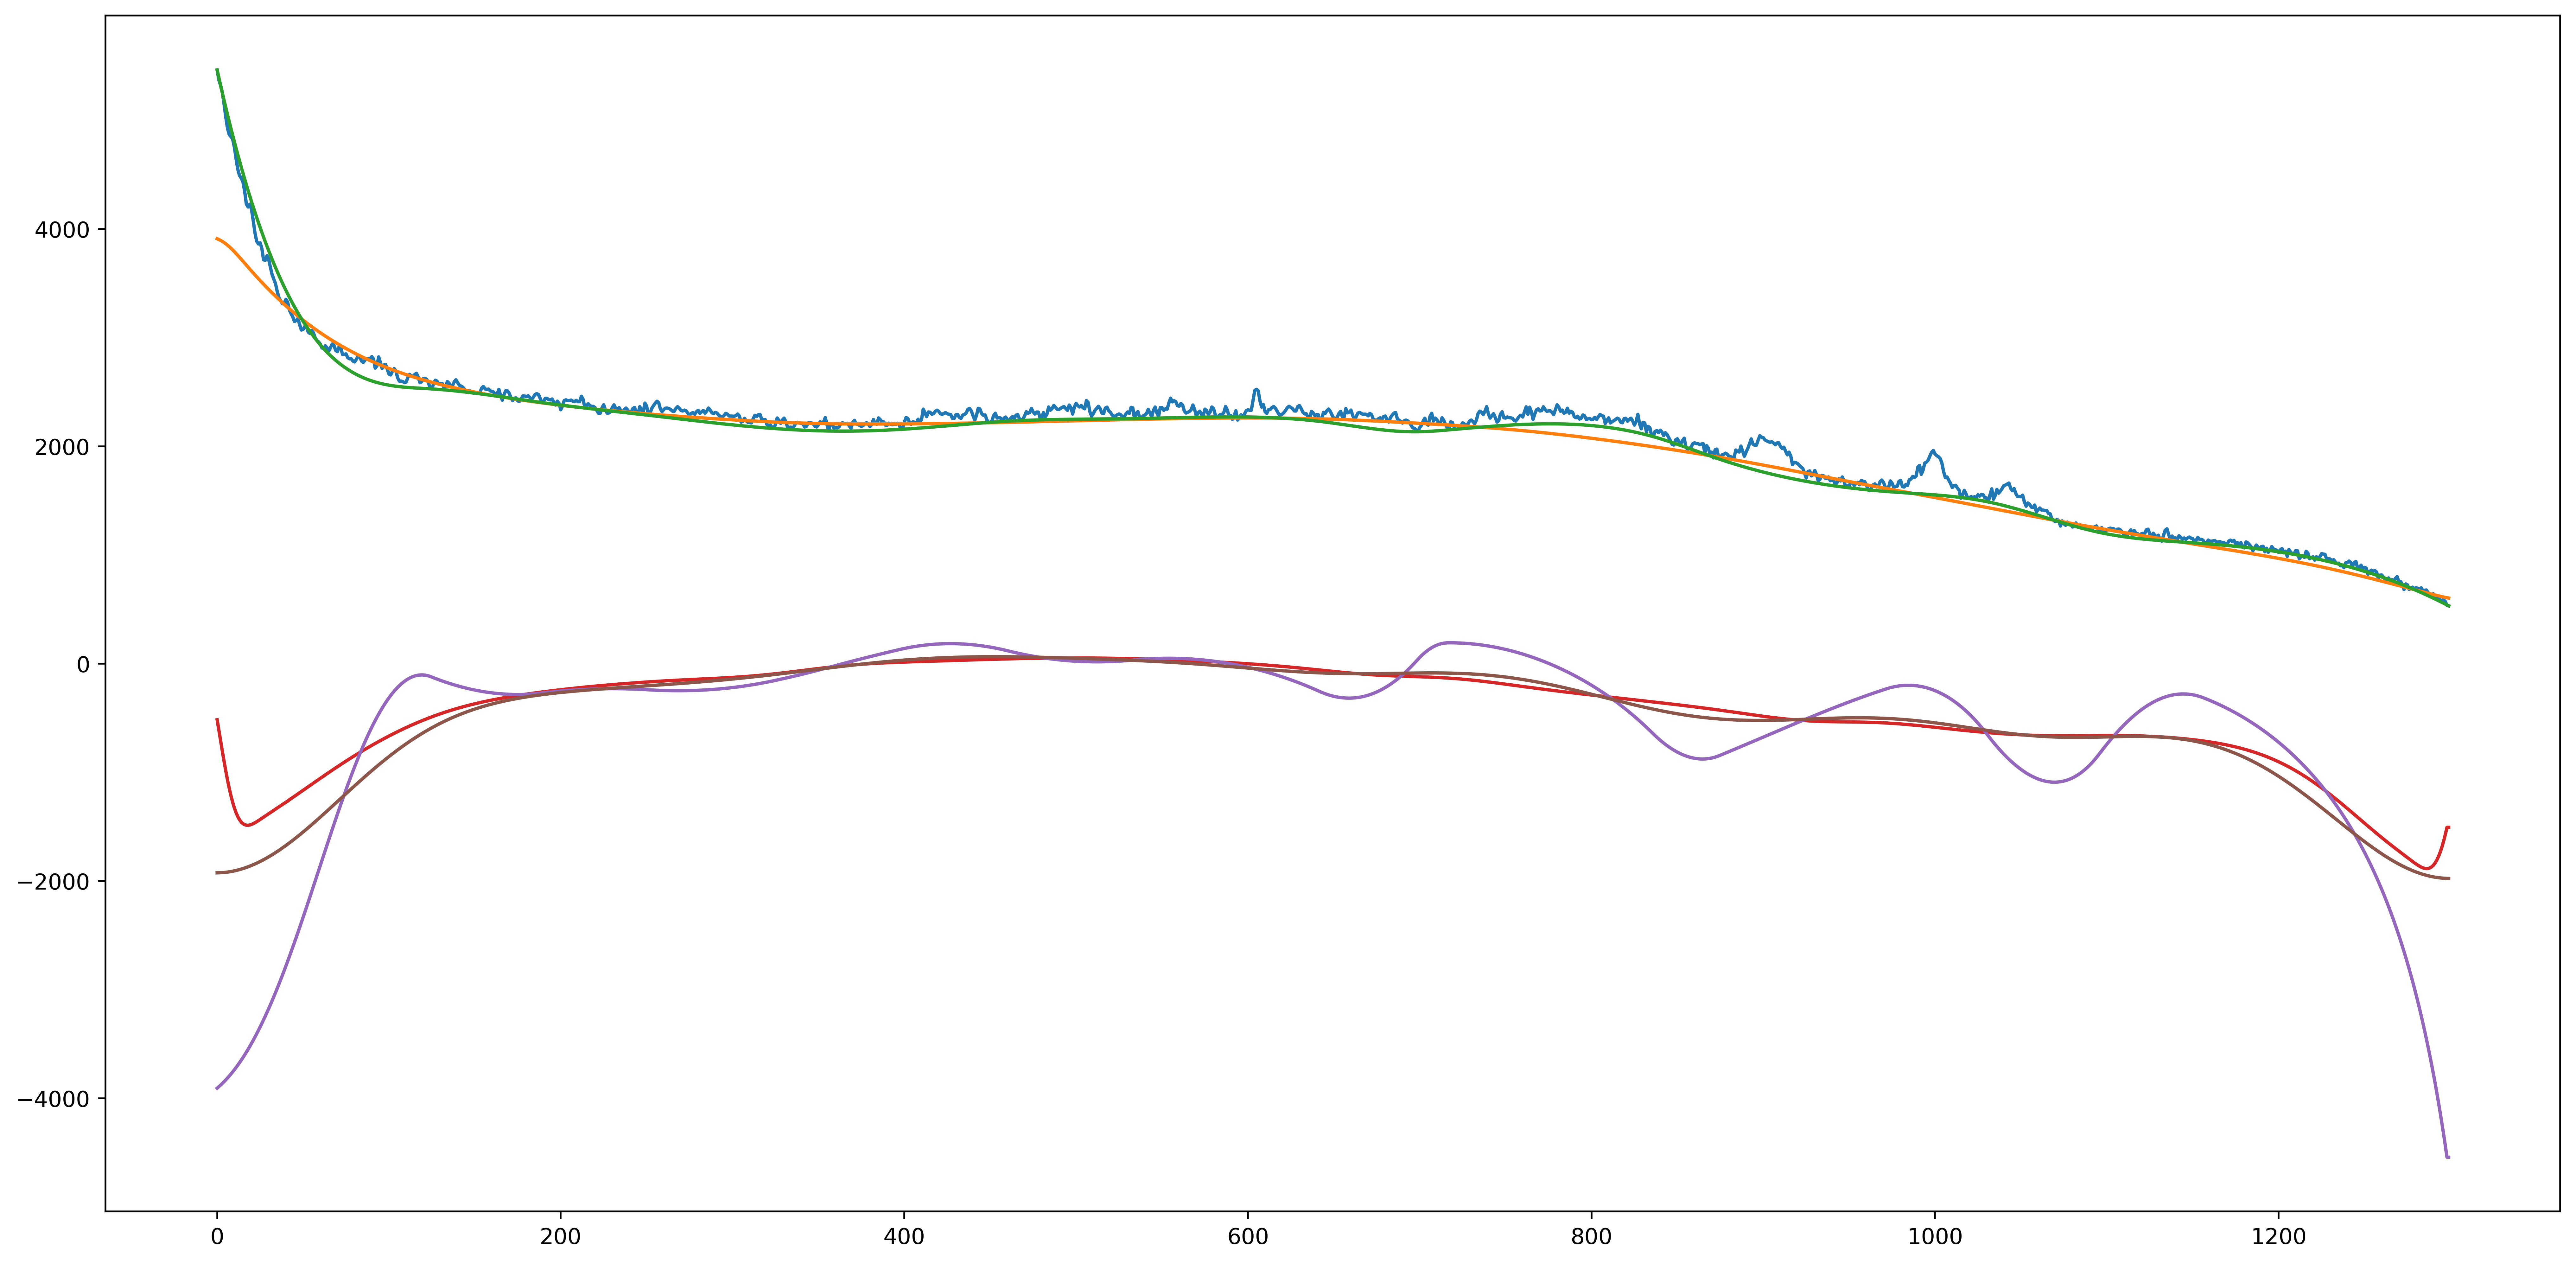

In [7]:
grad = np.pad(x2[:,1:] / x2[:,:-1],((0,0), (0, 1)), 'edge')[0]
grad2 = np.pad(x3[1:] / x3[:-1],(0, 1), 'edge')
grad3 = ndimage.gaussian_filter((grad2+grad)/2, 50)

plt.plot(x[0])
plt.plot(x2[0])
plt.plot(x3)
multi = 300000
plt.plot(grad*multi-multi)
plt.plot(grad2*multi-multi)
plt.plot(grad3*multi-multi)


In [8]:
class Kalman():
    def __init__(self, X, grad, e, neighbourhood):
        self.X = X
        self.C = np.array([[1,1],
                           [1,0]])
        self.A = np.zeros((X.shape[0], 2, 2))
        self.A[:,0,0] = grad
        self.A[:,1,1] = 1
        self.e = np.array([e, 0])
        self.n = neighbourhood
        self.mu = np.empty((X.shape[0], 2))
        self.M = np.empty((X.shape[0], 2, 2))
        self.nu = np.empty((X.shape[0]+1, 2))
        self.V = np.empty((X.shape[0]+1, 2, 2))
        
        self.nu[0] = [X[0,0], 0]
        
        # sigma[1,1]
        self.Sigma = np.array([[0.1, 0],
                               [0, 5]]) 
        self.Gamma = np.array([[0.003, 0],
                               [0, 0.3]])
        self.V[0] = [[0, 0],
                     [0, 0]]

    def _filter_step(self, i):
        
        CV = self.C @ self.V[i]
        b = self.C @ self.nu[i] + self.e
#         if i == 604:
#             self.Sigma[1,1] = 0
#             B = CV @ self.C + self.Sigma #C=C.T
#             self.Sigma[1,1] = 10
#         else:
        B = CV @ self.C + self.Sigma #C=C.T
        K = self.V[i] @ self.C @ np.linalg.inv(B)
        self.mu[i] = self.nu[i] + K @ (self.X[i] - b)
        self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.X.shape[0],i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
        self.M[i] = self.V[i] - K @ CV

        # transition
        self.nu[i+1] = self.A[i] @ self.mu[i]
        self.V[i+1] = self.A[i] @ self.M[i] @ self.A[i] + self.Gamma # A = A.T
        
    def _smoother_step(self, i):
        J = self.M[i-1] @ self.A[i] @ np.linalg.inv(self.V[i])
        self.M[i-1] += J @ (self.M[i] - self.V[i]) @ J.T
        self.mu[i-1] += J @ (self.mu[i] - self.nu[i])
#         self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.X.shape[0],i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
    
    def kalman_filter(self):
        for i in range(len(self.X)):
            self._filter_step(i)
            
    def kalman_smoother(self):
        self.kalman_filter()
        
        for i in range(len(self.X)-1, 0, -1):
            self._smoother_step(i)
            

black_noise = 0
obj = Kalman(np.stack((x[0], x2[0])).T, grad2, black_noise, 1)
obj.kalman_smoother()

# # emmision
# b = C @ nu
# B = C @ V @ C + Sigma #C=C.T
# K = C @ V @ np.linalg.inv(B)
# mu = nu + K @ (X[0]-b)
# M = V - K @ C @ V

# # transition
# nu = A @ mu
# V = A @ M @ A # A = A.T
plt.plot(x[0], label='raw')
# plt.plot(x2[0])
# plt.plot(obj.nu[1:,0])
# plt.plot(obj.nu[1:,1])
# plt.plot(obj.nu[1:,0]+obj.nu[1:,1])
plt.plot(obj.mu[:,0], label='photo')
plt.plot(obj.mu[:,1], label='raman')
plt.plot(obj.mu[:,0] + obj.mu[:,1] + black_noise, label='reconstructed signal')
plt.plot(x[0] - (obj.mu[:,0]+obj.mu[:,1] + black_noise), label='noise')
# plt.plot(2*[605], [0,5500], 'k', alpha=0.2)
plt.legend()
plt.show()

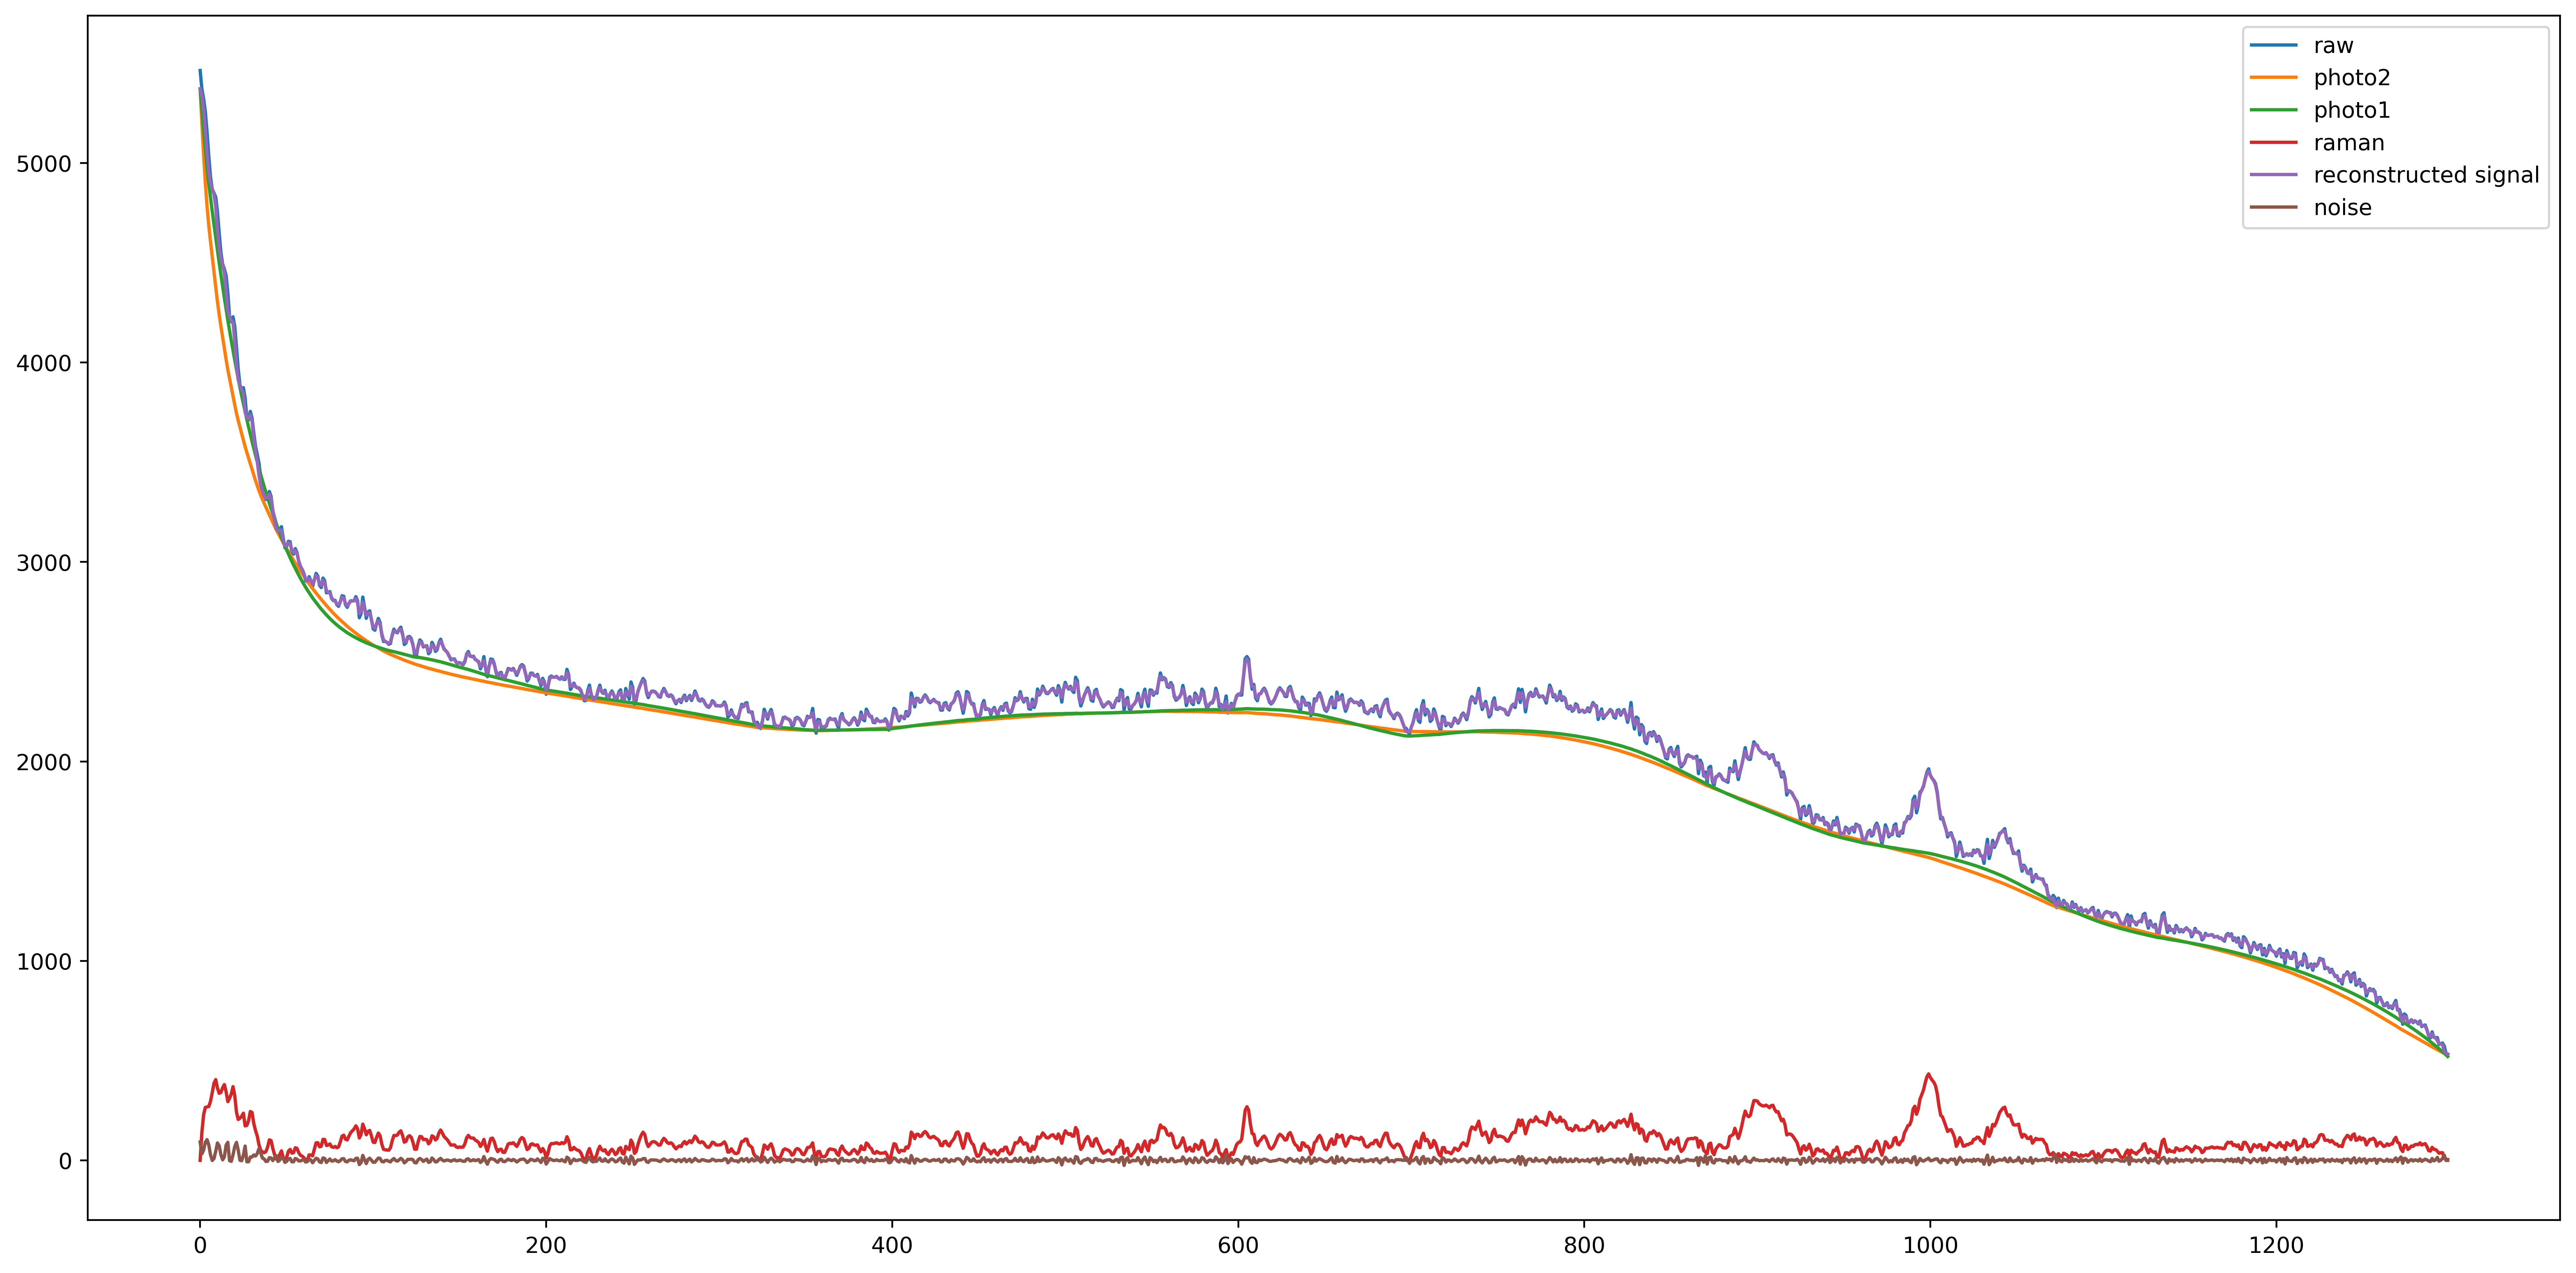

In [9]:
obj2 = Kalman(np.stack((x[0], obj.mu[:,0])).T, grad3, black_noise, 1)
obj2.kalman_smoother()

# # emmision
# b = C @ nu
# B = C @ V @ C + Sigma #C=C.T
# K = C @ V @ np.linalg.inv(B)
# mu = nu + K @ (X[0]-b)
# M = V - K @ C @ V

# # transition
# nu = A @ mu
# V = A @ M @ A # A = A.T
plt.plot(x[0], label='raw')
# plt.plot(x2[0])
# plt.plot(obj2.nu[1:,0])
# plt.plot(obj2.nu[1:,1])
# plt.plot(obj2.nu[1:,0]+obj.nu[1:,1])
plt.plot(obj2.mu[:,0], label='photo2')
plt.plot(obj.mu[:,0], label='photo1')
plt.plot(obj2.mu[:,1], label='raman')
plt.plot(obj2.mu[:,0] + obj2.mu[:,1] + black_noise, label='reconstructed signal')
plt.plot(x[0] - (obj2.mu[:,0]+obj2.mu[:,1] + black_noise), label='noise')
# plt.plot(2*[605], [0,5500], 'k', alpha=0.2)
plt.legend()
plt.show()

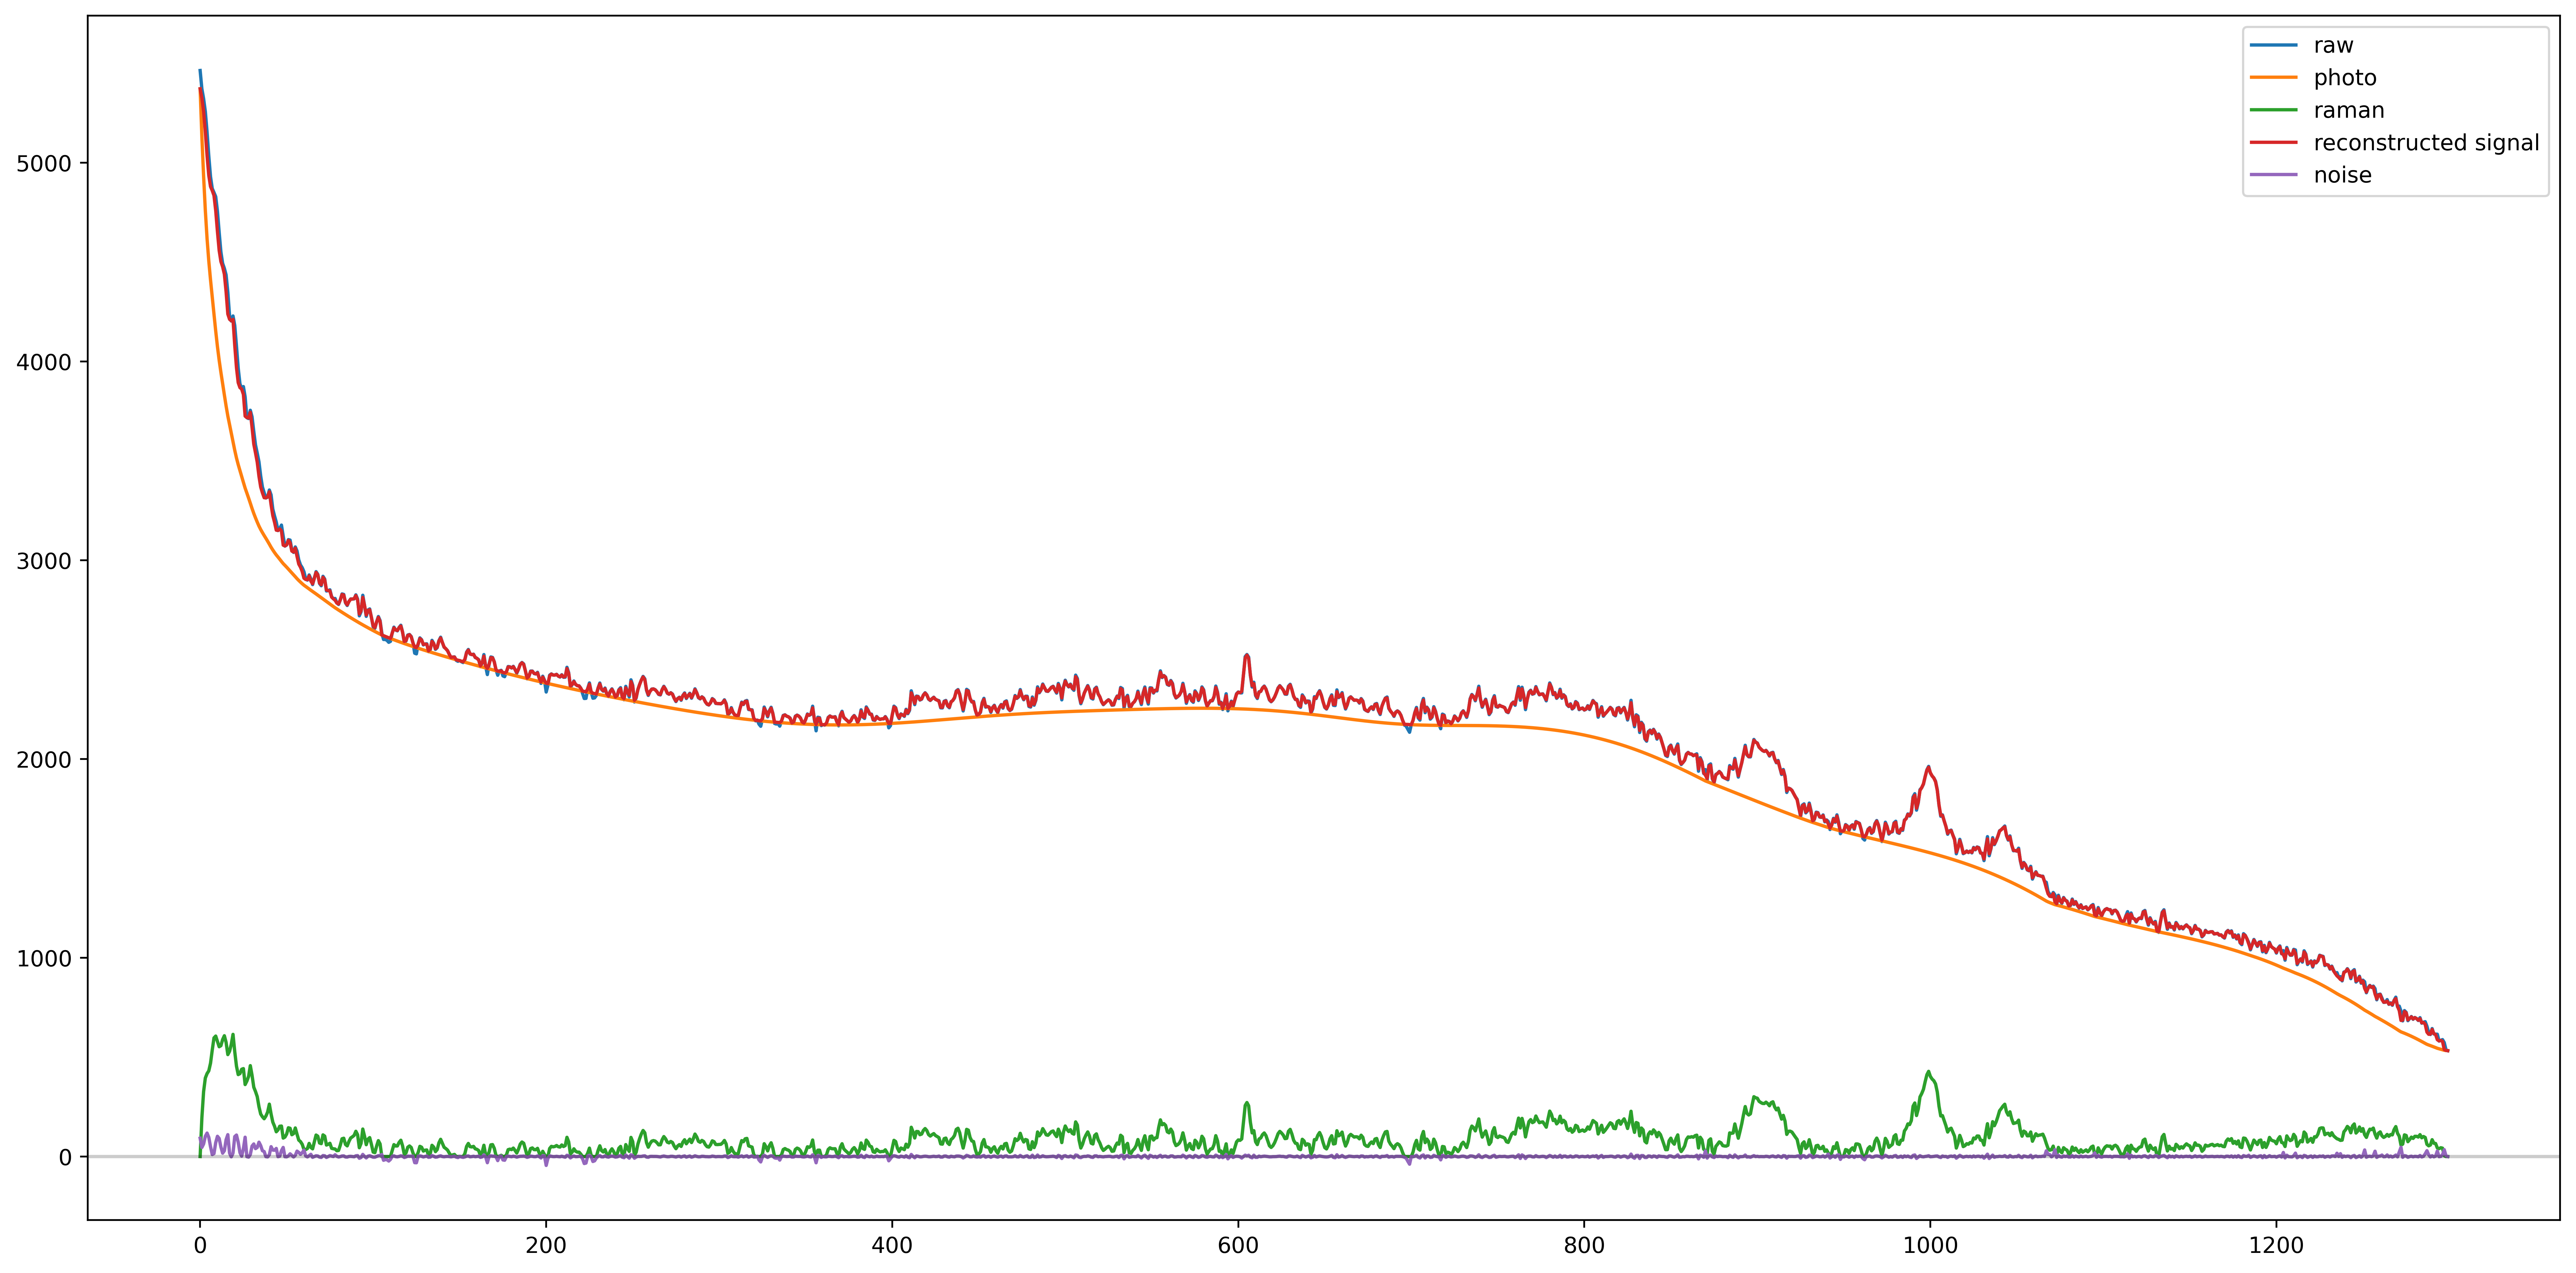

In [10]:
class Kalman3():
    def __init__(self, X, grad, e, neighbourhood):
        self.X = X
        self.C = np.array([[1,1],
                           [1,0],
                           [1,0]])
        self.A = np.zeros((X.shape[0], 2, 2))
        self.A[:,0,0] = grad
        self.A[:,1,1] = 1
        self.e = np.array([e, e, e])
        self.n = neighbourhood
        self.mu = np.empty((X.shape[0], 2))
        self.M = np.empty((X.shape[0], 2, 2))
        self.nu = np.empty((X.shape[0]+1, 2))
        self.V = np.empty((X.shape[0]+1, 2, 2))
        
        self.nu[0] = [X[0,0], 0]
        
        self.Sigma = np.array([[0.1,    0,   0],
                               [  0,  0.1,   0],
                               [  0, 0.05, 0.1]]) 
        self.Gamma = np.array([[0.0001, 0],
                               [0, 1]])
        self.V[0] = [[0, 0],
                     [0, 0]]


    def _filter_step(self, i):
        CV = self.C @ self.V[i]
        b = self.C @ self.nu[i] + self.e
        B = CV @ self.C.T + self.Sigma #C=C.T
        K = self.V[i] @ self.C.T @ np.linalg.inv(B)
        self.mu[i] = self.nu[i] + K @ (self.X[i] - b)
        self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.X.shape[0],i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
        self.M[i] = self.V[i] - K @ CV

        # transition
        self.nu[i+1] = self.A[i] @ self.mu[i]
        self.V[i+1] = self.A[i] @ self.M[i] @ self.A[i] + self.Gamma # A = A.T
        
    def _smoother_step(self, i):
        J = self.M[i-1] @ self.A[i] @ np.linalg.inv(self.V[i])
        self.M[i-1] += J @ (self.M[i] - self.V[i]) @ J.T
        self.mu[i-1] += J @ (self.mu[i] - self.nu[i])
#         self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.X.shape[0],i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
    
    def kalman_filter(self):
        for i in range(len(self.X)):
            self._filter_step(i)
            
    def kalman_smoother(self):
        self.kalman_filter()
        
        for i in range(len(self.X)-1, 0, -1):
            self._smoother_step(i)
            

black_noise = 0
obj = Kalman3(np.stack((x[0], x2[0], x3)).T, grad[0], black_noise, 1)
obj.kalman_smoother()

# # emmision
# b = C @ nu
# B = C @ V @ C + Sigma #C=C.T
# K = C @ V @ np.linalg.inv(B)
# mu = nu + K @ (X[0]-b)
# M = V - K @ C @ V

# # transition
# nu = A @ mu
# V = A @ M @ A # A = A.T
plt.plot(x[0], label='raw')
# plt.plot(x2[0])
# plt.plot(obj.nu[1:,0])
# plt.plot(obj.nu[1:,1])
# plt.plot(obj.nu[1:,0]+obj.nu[1:,1])
plt.plot(obj.mu[:,0], label='photo')
plt.plot(obj.mu[:,1], label='raman')
plt.plot(obj.mu[:,0] + obj.mu[:,1] + black_noise, label='reconstructed signal')
plt.plot(x[0] - (obj.mu[:,0]+obj.mu[:,1] + black_noise), label='noise')
# plt.plot(2*[605], [0,5500], 'k', alpha=0.2)
plt.legend()
plt.axhline(0, color='k', alpha=0.2)
plt.show()